<a href="https://colab.research.google.com/github/ronybot/NLP_HebrewEmbeding/blob/master/ResNet50_Similarity_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


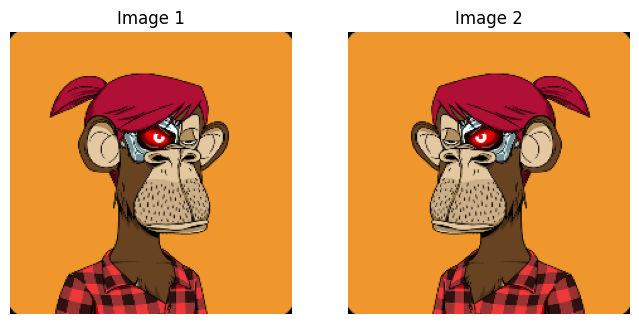

Label: 1


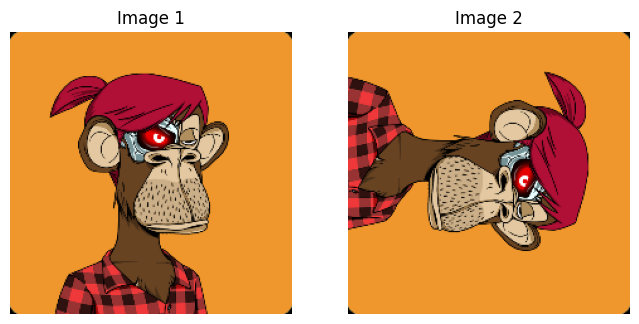

Label: 1


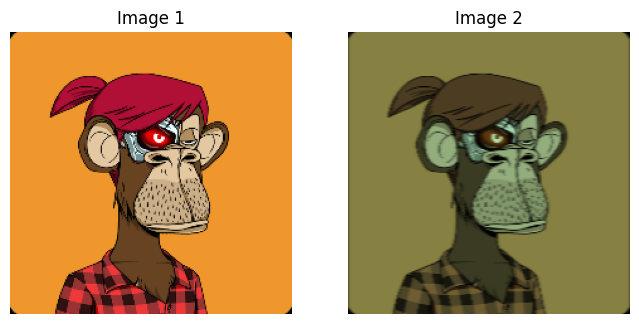

Label: 1


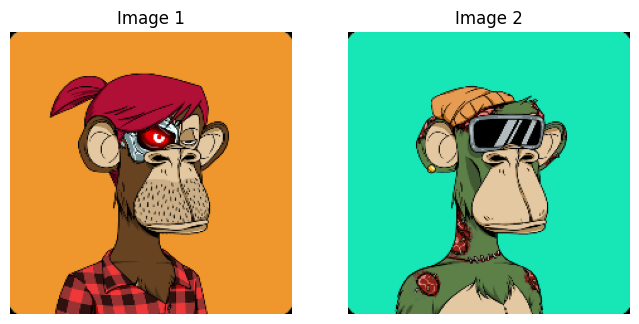

Label: 0


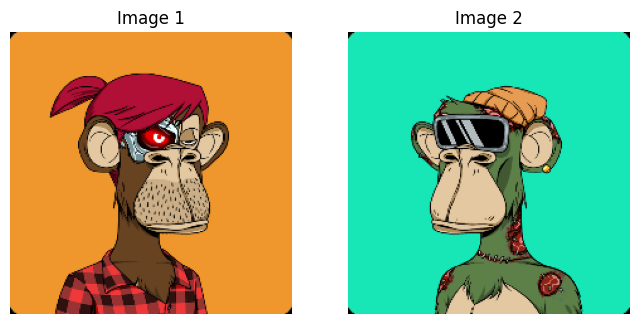

Label: 0


In [2]:
import tensorflow as tf
import numpy as np
import random
import os
import pandas as pd

import random

def get_random_value(not_need, max_value):
    value = random.randint(0, max_value)
    while value == not_need:
        value = random.randint(0, max_value)
    return value


directory = '/content/drive/MyDrive/find_similarity_resnet50/train'
file_paths = [os.path.join(directory, file) for file in os.listdir(directory)]
# df = pd.DataFrame({'image': file_names})

def gaussian_blur(image, sigma=1.0):
    # Define a Gaussian kernel
    kernel_size = int(sigma * 3) * 2 + 1  # Make sure the kernel size is odd
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
    y = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
    x, y = tf.meshgrid(x, y)
    kernel = tf.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    kernel /= tf.reduce_sum(kernel)

    # Apply the Gaussian filter
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    image = tf.nn.conv2d(image, tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1), strides=[1, 1, 1, 1], padding='SAME')
    image = tf.squeeze(image, axis=[0, -1])  # Remove batch and channel dimensions

    return image

# Function to preprocess and normalize images
def preprocess_main_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = tf.image.resize(image, (224, 224))  # Resize to input shape for ResNet50
    return image


def preprocess_flip_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = tf.image.resize(image, (224, 224))  # Resize to input shape for ResNet50
    image = tf.image.flip_left_right(image)  # Horizontal flip (left to right)
    return image


def preprocess_rotation_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = tf.image.resize(image, (224, 224))  # Resize to input shape for ResNet50

    # Rotate the image randomly
    k = tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32)  # Randomly choose rotation angle (0, 90, 180, or 270 degrees)
    image = tf.image.rot90(image, k=k)

    return image



def preprocess_gaussian_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = tf.image.resize(image, (224, 224))  # Resize to input shape for ResNet50

    # Apply Gaussian blur
    image = gaussian_blur(image, sigma=1)

    return image




# Generate pairs of images and their corresponding labels
def generate_pairs(dataset):
    pairs = []
    labels = []


    for index in range(len(dataset)):
        # Select a random pair of images from the dataset
        image_list=dataset[index]


        image1 = preprocess_main_image(image_list)
        image2 = preprocess_flip_image(image_list)
        label = 1
        pairs.append((image1, image2))
        labels.append(label)


        image1 = preprocess_main_image(image_list)
        image2 = preprocess_rotation_image(image_list)
        label = 1
        pairs.append((image1, image2))
        labels.append(label)



        image1 = preprocess_main_image(image_list)
        image2 = preprocess_gaussian_image(image_list)
        label = 1
        pairs.append((image1, image2))
        labels.append(label)





        max_value=len(dataset)-1

        image1 = preprocess_main_image(image_list)
        image2 = preprocess_main_image(dataset[get_random_value(index, max_value)])
        label = 0
        pairs.append((image1, image2))
        labels.append(label)


        image1 = preprocess_main_image(image_list)
        image2 = preprocess_flip_image(dataset[get_random_value(index, max_value)])
        label = 0
        pairs.append((image1, image2))
        labels.append(label)


        image1 = preprocess_main_image(image_list)
        image2 = preprocess_rotation_image(dataset[get_random_value(index, max_value)])
        label = 0
        pairs.append((image1, image2))
        labels.append(label)



        image1 = preprocess_main_image(image_list)
        image2 = preprocess_gaussian_image(dataset[get_random_value(index, max_value)])
        label = 0
        pairs.append((image1, image2))
        labels.append(label)









    return np.array(pairs), np.array(labels)

# Generate small training dataset
num_pairs = 100  # Adjusted for a small dataset size
X_train, y_train = generate_pairs(file_paths)

# Example of a pair
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i][0])
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(X_train[i][1])
    plt.title('Image 2')
    plt.axis('off')

    plt.show()

    # Check the label
    print('Label:', y_train[i])



In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense


def create_siamese_network(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the layers of the ResNet50 model
    for layer in base_model.layers[:30]:
        layer.trainable = False

    # Define the two identical branches of the Siamese network
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    # Calculate the Euclidean distance between the processed images
    distance = layers.Lambda(lambda x:
                              K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)))([processed_a, processed_b])

    flatten_layer = Flatten()(distance)

    # Add fully connected layers
    dense1 = Dense(128, activation='relu')(flatten_layer)
    dense2 = Dense(64, activation='relu')(dense1)

    # Add a dense layer for producing a single scalar output
    dense_layer = layers.Dense(1, activation='sigmoid')(dense2)

    # Create the Siamese network model
    siamese_model = models.Model(inputs=[input_a, input_b], outputs=dense_layer)
    return siamese_model


# Example usage:
input_shape = (224, 224, 3)  # Input shape for ResNet50
siamese_model = create_siamese_network(input_shape)
siamese_model.summary()


94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_2[0][0]',             
                                                          2          'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Compile the Siamese network model
siamese_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])


# Train the model
history = siamese_model.fit([X_train[:, 0], X_train[:, 1]], y_train, batch_size=32, epochs=100)

# Evaluate the model (optional)
# Assuming you have a separate validation set X_val and y_val
loss, accuracy = siamese_model.evaluate([X_train[:, 0], X_train[:, 1]], y_train)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

Epoch 1/100
24/24 [==============================] - 992s 40s/step - loss: 2.8460 - accuracy: 0.6839
Epoch 2/100
24/24 [==============================] - 944s 39s/step - loss: 0.3867 - accuracy: 0.8386
Epoch 3/100
 9/24 [==========>...................] - ETA: 10:04 - loss: 0.2140 - accuracy: 0.9167

In [ ]:
# Preprocess the images (assuming preprocess_image function is defined)
image_list=random.choice(file_paths)
processed_image1 = preprocess_main_image(image_list)
processed_image2 = preprocess_gaussian_image(image_list)

# Reshape the images to match the Siamese network input shape
processed_image1 = np.expand_dims(processed_image1, axis=0)
processed_image2 = np.expand_dims(processed_image2, axis=0)

# Use the trained Siamese network model to predict the similarity
similarity_score = siamese_model.predict([processed_image1, processed_image2])

print("Similarity score between the two images:", similarity_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Similarity score between the two images: [[1.]]


In [ ]:
similarity_scores_gaussian=[]
similarity_scores_flip=[]
similarity_scores_rotation=[]
for url in file_paths:

#     fig, axs = plt.subplots(1, 4, figsize=(15, 5))


    processed_image1 = preprocess_main_image(url)
    processed_image2 = preprocess_gaussian_image(url)
    processed_image1 = np.expand_dims(processed_image1, axis=0)
    processed_image2 = np.expand_dims(processed_image2, axis=0)
    gaussian_score=siamese_model.predict([processed_image1, processed_image2])
    similarity_scores_gaussian.append(gaussian_score)

#     axs[0].imshow(processed_image1[0])
#     axs[0].set_title('Similarity Scores (Gaussian)')
#     axs[0].set_xlabel('Samples')
#     axs[0].set_ylabel('Similarity')

#     axs[1].imshow(processed_image2[0])
#     axs[1].set_title('Similarity Scores (Gaussian)')
#     axs[1].set_xlabel('Samples')
#     axs[1].set_ylabel('Similarity')


    processed_image1 = preprocess_main_image(url)
    processed_image2 = preprocess_rotation_image(url)
    processed_image1 = np.expand_dims(processed_image1, axis=0)
    processed_image2 = np.expand_dims(processed_image2, axis=0)
    rotation_score=siamese_model.predict([processed_image1, processed_image2])
    similarity_scores_rotation.append(rotation_score)

#     axs[2].imshow(processed_image2[0])
#     axs[2].set_title('Similarity Scores (Rotation)')
#     axs[2].set_xlabel('Samples')
#     axs[2].set_ylabel('Similarity')



    processed_image1 = preprocess_main_image(url)
    processed_image2 = preprocess_flip_image(url)
    processed_image1 = np.expand_dims(processed_image1, axis=0)
    processed_image2 = np.expand_dims(processed_image2, axis=0)
    flip_score=siamese_model.predict([processed_image1, processed_image2])
    similarity_scores_flip.append(flip_score)


#     axs[3].imshow(processed_image2[0])
#     axs[3].set_title('Similarity Scores (Flip)')
#     axs[3].set_xlabel('Samples')
#     axs[3].set_ylabel('Similarity')

#     plt.tight_layout()  # Adjust layout to prevent overlap
#     plt.show()
#     print(f"Similarity (Gaussian): {gaussian_score}, Similarity (Rotation): {rotation_score}, Similarity (Flip): {flip_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [ ]:
for result in zip(file_paths, similarity_scores_gaussian, similarity_scores_flip, similarity_scores_rotation):
    print(f"URL: {result[0].split('/')[-1]}, Similarity (Gaussian): {result[1]}, Similarity (Flip): {result[2]}, Similarity (Rotation): {result[3]}")

URL: 7124b9738f8d18e9c0775c9e107b1c52.png, Similarity (Gaussian): [[1.]], Similarity (Flip): [[1.]], Similarity (Rotation): [[0.9999894]]
URL: QmZi5m4oYYkZumJd1anmNmJMeJqV3Gvcz6kcgZ1J3dQo1f.png, Similarity (Gaussian): [[1.]], Similarity (Flip): [[0.9999999]], Similarity (Rotation): [[0.99965847]]
URL: QmZQ1BZen5ePpUR4zrfLgxdUVuZrXmyMsgP4eb83gtAJXu.png, Similarity (Gaussian): [[1.]], Similarity (Flip): [[0.99999857]], Similarity (Rotation): [[1.]]
URL: QmQRMzNX9bcdnEuMx4qhsQGWxJ2BA3BNZZVybu3nZxma5d.png, Similarity (Gaussian): [[0.9999993]], Similarity (Flip): [[0.9999999]], Similarity (Rotation): [[0.9999956]]
URL: QmZ3cTwARkfhztr43cXYWXjftJZFinkdzUFzgMH9eSXAmg.png, Similarity (Gaussian): [[0.99999416]], Similarity (Flip): [[0.99999976]], Similarity (Rotation): [[1.]]
URL: QmcaEumnTbujyzzV55DXK536Q5gVZ1S2rCooDkU9wixY5H.png, Similarity (Gaussian): [[0.9999999]], Similarity (Flip): [[0.9999995]], Similarity (Rotation): [[0.3715221]]
URL: 29df7a433d19971eaba89e8c0a74a711.png, Similarity (G

In [ ]:
import csv

# Assuming you have defined file_paths, similarity_scores_gaussian, similarity_scores_flip, and similarity_scores_rotation

# Specify the file name for your CSV file
csv_file = "/content/drive/MyDrive/find_similarity_resnet50/results.csv"

# Open the CSV file in write mode
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(["URL", "Similarity (Gaussian)", "Similarity (Flip)", "Similarity (Rotation)"])

    # Write each result row
    for result in zip(file_paths, similarity_scores_gaussian, similarity_scores_flip, similarity_scores_rotation):
        writer.writerow([result[0].split('/')[-1], result[1], result[2], result[3]])

print(f"Results have been saved to {csv_file}")


Results have been saved to /kaggle/working/results.csv
